In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table as Table
import matplotlib.pyplot as plt
from linetools.spectra import utils as ltsu
from linetools.spectra.xspectrum1d import XSpectrum1D
import astropy.units as u
from astropy import constants as const
from numpy import random as ran
%matplotlib inline

# The stack. It is the exact same procedure as in the "stack_2.5" notebook

In [2]:
#the 2016 survey

#to order and match the spec with their z values
spec_atr_16 = Table.read('/home/jsm/Research/2018-2019/Spectra/old_spec/spec_atr.txt', format = 'ascii') 

#an initial filter to ensure the spec included cover lya
basestring_16 = '/home/jsm/Research/2018-2019/Spectra/old_spec/'

init_spec_16 = []

init_z_16 = []
    
for entry in spec_atr_16:
    
    if 2.0 < entry["zspec"] < 2.5: #the redshift bin
        
        temp = XSpectrum1D.from_file(basestring_16 + entry["Filename"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["zspec"]) < temp.wvmax:
                
            init_z_16.append(entry["zspec"])
                
            init_spec_16.append(XSpectrum1D.from_file(basestring_16 + entry["Filename"]))

In [3]:
#the 2017 survey

#to order and match the spec with their z values
spec_atr_17 = Table.read('/home/jsm/Research/2018-2019/Spectra/new_spec/cl2017_redux/cl2017_valueadded_release_20171009.txt',
                         format = 'ascii') 

#an initial filter to ensure the spec included cover lya
basestring_17 = '/home/jsm/Research/2018-2019/Spectra/new_spec/cl2017_redux/spec_v0/'

init_spec_17 = []

init_z_17 = []
    
for entry in spec_atr_17:
    
    if 2.0 < entry["col5"] < 2.5: #the redshift bin
        
        temp = XSpectrum1D.from_file(basestring_17 + entry["col1"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["col5"]) < temp.wvmax:
                
            init_z_17.append(entry["col5"])
                
            init_spec_17.append(XSpectrum1D.from_file(basestring_17 + entry["col1"]))

/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [4]:
spec = np.asarray(init_spec_16 + init_spec_17)

print("Number of spectra (Nspec) after filter =", len(spec))

red = np.asarray(init_z_16 + init_z_17)

Number of spectra (Nspec) after filter = 285


In [5]:
# the normalization

r_2  = range(len(spec))

temp_2 = [np.asarray(spec[i].wavelength/(1+red[i])) for i in r_2]

wv_norm_1 = [ (1270 < entry) & (entry < 1300) for entry in temp_2 ]

wv_norm_2 = [ (1308 < entry) & (entry < 1330) for entry in temp_2 ]

wv_norm_3 = [ (1340 < entry) & (entry < 1390) for entry in temp_2 ]

wv_norm_4 = [ (1410 < entry) & (entry < 1450) for entry in temp_2 ]


In [6]:
wv_norm = []

for i in range(len(temp_2)):
    
    wv_norm.append(wv_norm_1[i] | wv_norm_2[i] | wv_norm_3[i] | wv_norm_4[i])

In [7]:
stiched_range = np.asarray([spec[i].flux[wv_norm[i]] for i in r_2])   

medians = np.asarray([np.median(stiched_range[i]) for i in r_2])

In [8]:
norm_flux = np.asarray([(spec[i].flux/medians[i]) for i in r_2])

In [9]:
#the new scaled Xspec objects

scaled_spec = []

for i in r_2:       
    
    scaled_spec.append(XSpectrum1D(spec[i].wavelength,norm_flux[i],sig=spec[i].sig))

/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/linetools-0.3.dev2065-py3.5.egg/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [10]:
bad_ind = [1,6,14,17,24,25,27,29,33,34,37,39,41,42,46,47,51,59,65,71,87,92,97,101,104,
        105,113,115,118,121,126,136,142,147,149,151,159,161,169,177,207,212,222,238,264,266,278]

scaled_spec = np.delete(scaled_spec,bad_ind)

red = np.delete(red,bad_ind)

In [11]:
#the first trim on the wavelegth array to ensure a solid stack [440:1500]

trim_spec = []

for i in range(len(scaled_spec)):       
    
    trim_spec.append(XSpectrum1D(scaled_spec[i].data["wave"][0][600:850],
                                scaled_spec[i].data["flux"][0][600:850],
                                scaled_spec[i].data["sig"][0][600:850]))
    
print("Number of spectra to be stacked =", len(trim_spec))

Number of spectra to be stacked = 238


/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/linetools-0.3.dev2065-py3.5.egg/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [44]:
collate_1 = ltsu.collate(trim_spec[125:130])

collate_2 = ltsu.collate(trim_spec[0:70])

collate_3 = ltsu.collate(trim_spec[0:130])

collate_4 = ltsu.collate(trim_spec)

In [45]:
rest_spec_1 = ltsu.rebin_to_rest(collate_1, red[125:130], 150*u.km/u.s,grow_bad_sig = True)

rest_spec_2 = ltsu.rebin_to_rest(collate_2, red[0:70], 150*u.km/u.s,grow_bad_sig = True)

rest_spec_3 = ltsu.rebin_to_rest(collate_3, red[0:130], 150*u.km/u.s,grow_bad_sig = True)

rest_spec_4 = ltsu.rebin_to_rest(collate_4, red, 150*u.km/u.s,grow_bad_sig = True)

In [46]:
stack_1 = ltsu.smash_spectra(rest_spec_1)

stack_2 = ltsu.smash_spectra(rest_spec_2)

stack_3 = ltsu.smash_spectra(rest_spec_3)

stack_4 = ltsu.smash_spectra(rest_spec_4)

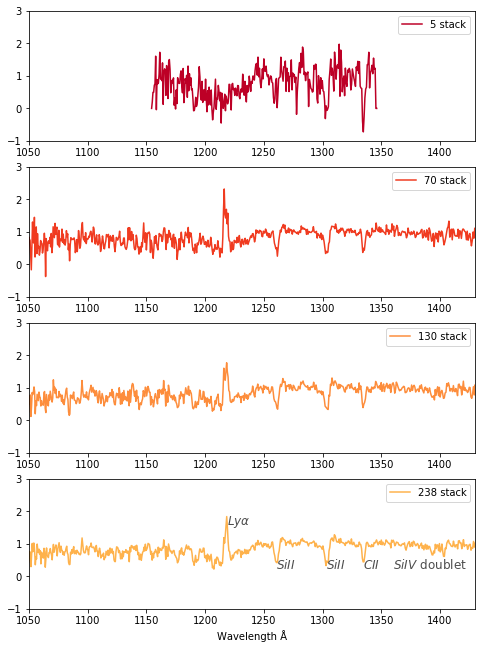

In [56]:
fig, ax = plt.subplots(figsize=(8,11))


plt.subplot(4, 1, 1)
plt.plot(stack_1.wavelength, stack_1.flux,label="5 stack",color="#bd0026")
plt.xlim(1050,1430)
plt.ylim(-1,3)
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(stack_2.wavelength, stack_2.flux,label="70 stack",color="#f03b20")
plt.xlim(1050,1430)
plt.ylim(-1,3)
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(stack_3.wavelength, stack_3.flux,label="130 stack",color="#fd8d3c")
plt.xlim(1050,1430)
plt.ylim(-1,3)
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(stack_4.wavelength, stack_4.flux,label="238 stack",color="#feb24c")
plt.xlim(1050,1430)
plt.ylim(-1,3)
plt.text(1260.42,.25,"$SiII$",fontsize=12,color="#4d4d4d")
plt.text(1303.1685,.25,"$SiII$",fontsize=12,color="#4d4d4d")
plt.text(1334.5323,.25,"$CII$",fontsize=12,color="#4d4d4d")
plt.text(1360,.25,"$SiIV$ doublet",fontsize=12,color="#4d4d4d")
plt.text(1219,1.6,"$Lyα$",fontsize=12,color="#4d4d4d")
plt.xlabel("Wavelength Å")
plt.legend()

plt.show()

fig.savefig("/home/jsm/my_lbg_da/lbg_da/summer_2018/figures/png/Stacking_effects.png",bbox_inches='tight')
